In [ ]:
pip install tensorflow matplotlib


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - kl_loss: 0.0039 - loss: 0.3087 - reconstruction_loss: 0.3048
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - kl_loss: 1.8725e-04 - loss: 0.2639 - reconstruction_loss: 0.2637
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - kl_loss: 4.8203e-05 - loss: 0.2633 - reconstruction_loss: 0.2632
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - kl_loss: 1.8737e-05 - loss: 0.2631 - reconstruction_loss: 0.2631
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - kl_loss: 9.0789e-06 - loss: 0.2631 - reconstruction_loss: 0.2631
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - kl_loss: 5.2192e-06 - loss: 0.2631 - reconstruction_loss: 0.2631
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - kl_loss: 3.2727e-06 - loss: 0.2631 - reconstruction_loss: 0.2631
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - kl_loss: 2.3919e-06 - loss: 0.2630 - reconstruction_loss:

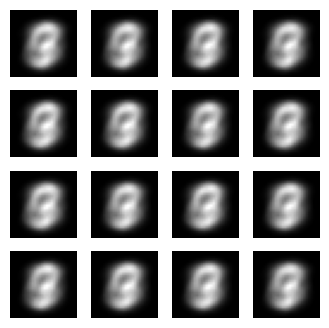

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt
import os

# ----------------------------
# Configuration
# ----------------------------
latent_dim = 2
epochs = 10
batch_size = 128
os.makedirs("vae_results", exist_ok=True)

# ----------------------------
# Load MNIST
# ----------------------------
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# ----------------------------
# Sampling Layer
# ----------------------------
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# ----------------------------
# Encoder
# ----------------------------
encoder_inputs = layers.Input(shape=(28, 28, 1))
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(256, activation="relu")(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)
z = Sampling()([z_mean, z_log_var])

encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# ----------------------------
# Decoder
# ----------------------------
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(256, activation="relu")(latent_inputs)
x = layers.Dense(28 * 28, activation="sigmoid")(x)
decoder_outputs = layers.Reshape((28, 28, 1))(x)

decoder = Model(latent_inputs, decoder_outputs, name="decoder")

# ----------------------------
# VAE Model
# ----------------------------
class VAE(Model):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            recon_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(data, reconstruction)
            )
            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )

            total_loss = recon_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {
            "loss": total_loss,
            "reconstruction_loss": recon_loss,
            "kl_loss": kl_loss
        }

# ----------------------------
# Train
# ----------------------------
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())

vae.fit(
    x_train,
    epochs=epochs,
    batch_size=batch_size
)

# ----------------------------
# Generate Images
# ----------------------------
random_latent = np.random.normal(size=(16, latent_dim))
generated = decoder.predict(random_latent)

plt.figure(figsize=(4, 4))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(generated[i].reshape(28, 28), cmap="gray")
    plt.axis("off")

plt.savefig("vae_results/generated.png")
plt.show()


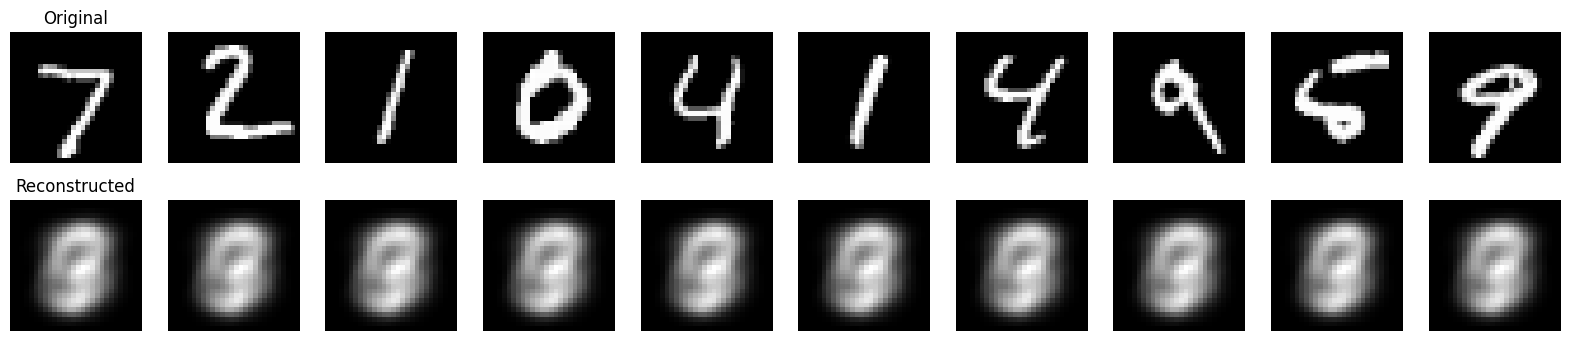

In [ ]:
# ----------------------------
# Reconstruction Visualization
# ----------------------------
n = 10  # number of images
reconstructed = vae.decoder(
    vae.encoder(x_test[:n])[2]
)

plt.figure(figsize=(20, 4))

# Original images
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    plt.axis("off")
    if i == 0:
        ax.set_title("Original")

# Reconstructed images
for i in range(n):
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i].numpy().reshape(28, 28), cmap="gray")
    plt.axis("off")
    if i == 0:
        ax.set_title("Reconstructed")

plt.show()


In [ ]:
# ----------------------------
# Reconstruction & KL Loss
# ----------------------------
z_mean, z_log_var, z = encoder(x_test[:batch_size])
recon = decoder(z)

recon_loss = tf.reduce_mean(
    tf.keras.losses.binary_crossentropy(x_test[:batch_size], recon)
)

kl_loss = -0.5 * tf.reduce_mean(
    1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
)

print("Reconstruction Loss:", recon_loss.numpy())
print("KL Divergence Loss:", kl_loss.numpy())


Reconstruction Loss: 0.25239834
KL Divergence Loss: 6.269547e-06


In [ ]:
latent_dim = 2


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


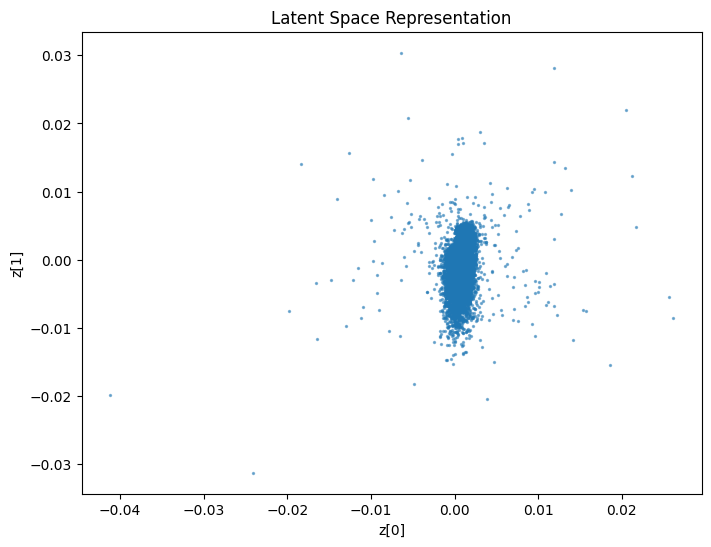

In [ ]:
# ----------------------------
# Latent Space Visualization
# ----------------------------
z_mean, _, _ = encoder.predict(x_test, batch_size=128)

plt.figure(figsize=(8, 6))
plt.scatter(z_mean[:, 0], z_mean[:, 1], s=2, alpha=0.5)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title("Latent Space Representation")
plt.show()


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


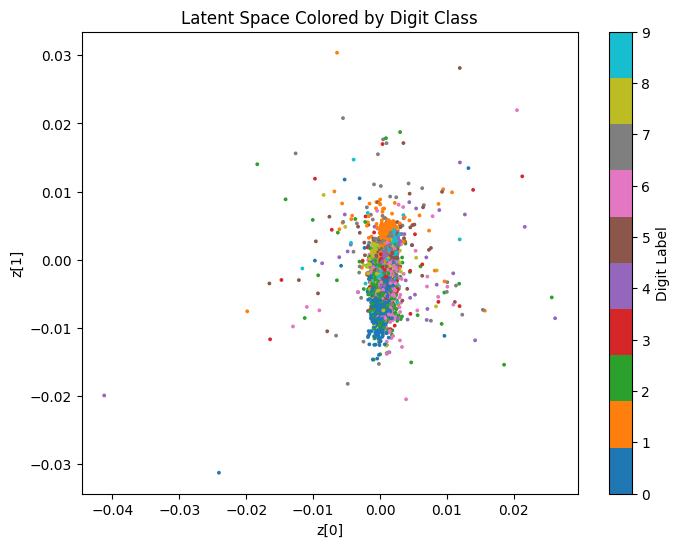

In [ ]:
(_, y_test) = tf.keras.datasets.mnist.load_data()[1]

z_mean, _, _ = encoder.predict(x_test, batch_size=128)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    z_mean[:, 0], z_mean[:, 1],
    c=y_test, cmap="tab10", s=3
)
plt.colorbar(scatter, label="Digit Label")
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title("Latent Space Colored by Digit Class")
plt.show()


In [ ]:
total_loss = recon_loss + 0.1 * kl_loss


In [ ]:
# ----------------------------
# KL Statistics Verification
# ----------------------------
z_mean, z_log_var, _ = encoder.predict(x_test[:1000], batch_size=128)

print("Mean of z_mean:", np.mean(z_mean, axis=0))
print("Std of z_mean:", np.std(z_mean, axis=0))
print("Mean log variance:", np.mean(z_log_var, axis=0))
print("Std log variance:", np.std(z_log_var, axis=0))



8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Mean of z_mean: [ 0.00073681 -0.00023088]
Std of z_mean: [0.00221166 0.00331553]
Mean log variance: [-0.0004015   0.00050195]
Std log variance: [0.00195204 0.00139128]


In [ ]:
recon_history = []
kl_history = []


In [ ]:
recon_history.append(recon_loss.numpy())
kl_history.append(kl_loss.numpy())


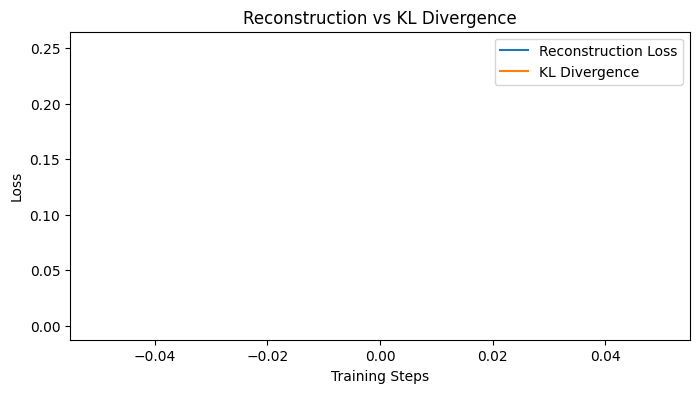

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(recon_history, label="Reconstruction Loss")
plt.plot(kl_history, label="KL Divergence")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.legend()
plt.title("Reconstruction vs KL Divergence")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━

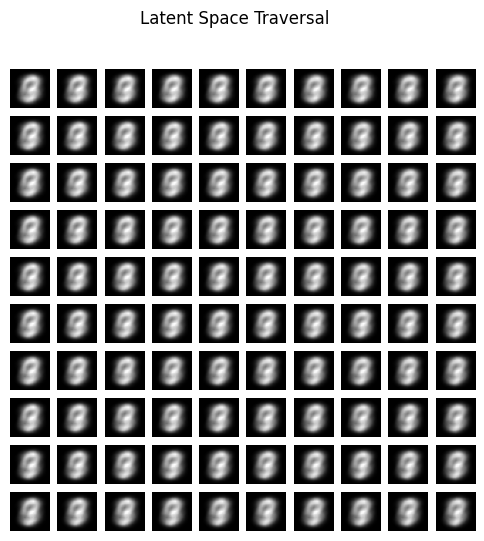

In [ ]:
# ----------------------------
# Latent Traversal
# ----------------------------
grid_x = np.linspace(-2, 2, 10)
grid_y = np.linspace(-2, 2, 10)

plt.figure(figsize=(6, 6))

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z = np.array([[xi, yi]])
        x_decoded = decoder.predict(z)
        digit = x_decoded[0].reshape(28, 28)

        ax = plt.subplot(10, 10, i * 10 + j + 1)
        plt.imshow(digit, cmap="gray")
        plt.axis("off")

plt.suptitle("Latent Space Traversal")
plt.show()


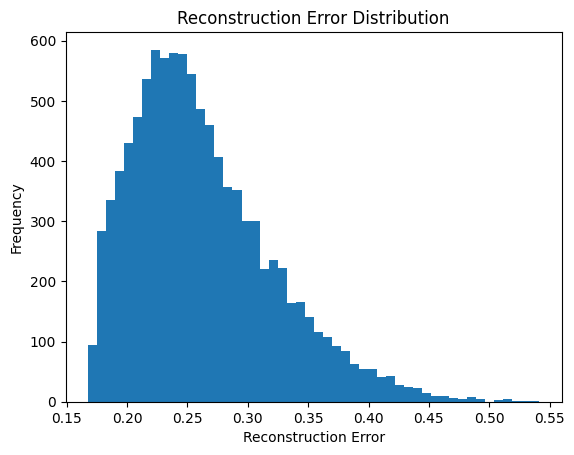

In [ ]:
# ----------------------------
# Reconstruction Error Histogram
# ----------------------------
recon = decoder(encoder(x_test)[2])
recon_error = tf.reduce_mean(
    tf.keras.losses.binary_crossentropy(x_test, recon),
    axis=(1, 2)
)

plt.hist(recon_error.numpy(), bins=50)
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Reconstruction Error Distribution")
plt.show()


In [ ]:
latent_dim = 8        # instead of 2
beta = 0.01           # weaker KL
epochs = 50


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

x_train = np.expand_dims(x_train, -1)
x_test  = np.expand_dims(x_test, -1)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [ ]:
latent_dim = 2   # keep 2 for visualization

encoder_inputs = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 7, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    401,536 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │        258 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │        258 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 420,868 (1.61 MB)

 Trainable params: 420,868 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3136)           │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class VAE(Model):
    def __init__(self, encoder, decoder, beta=0.01):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            recon_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )

            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )

            total_loss = recon_loss + self.beta * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {
            "loss": total_loss,
            "reconstruction_loss": recon_loss,
            "kl_loss": kl_loss
        }


In [ ]:
vae = VAE(encoder, decoder, beta=0.01)
vae.compile(optimizer=tf.keras.optimizers.Adam())

history = vae.fit(
    x_train,
    epochs=40,
    batch_size=128
)


Epoch 1/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - kl_loss: 17.3718 - loss: 199.7823 - reconstruction_loss: 199.6086
Epoch 2/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - kl_loss: 13.3168 - loss: 157.0627 - reconstruction_loss: 156.9295
Epoch 3/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - kl_loss: 12.8627 - loss: 150.4184 - reconstruction_loss: 150.2898
Epoch 4/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - kl_loss: 12.9212 - loss: 147.3892 - reconstruction_loss: 147.2600
Epoch 5/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - kl_loss: 13.3742 - loss: 145.3374 - reconstruction_loss: 145.2036
Epoch 6/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 13.9929 - loss: 143.6692 - reconstruction_loss: 143.5293
Epoch 7/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - kl_loss: 14.4989 - loss: 142.4426 - reconstruction_loss: 142.2976
Epoch 8/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - kl_loss: 14.8031 - loss: 141.4690 - reconstruction_loss: 141.3209
Epoch 9/40
469/469 ━━━━━━━━━━━━━━━━━━

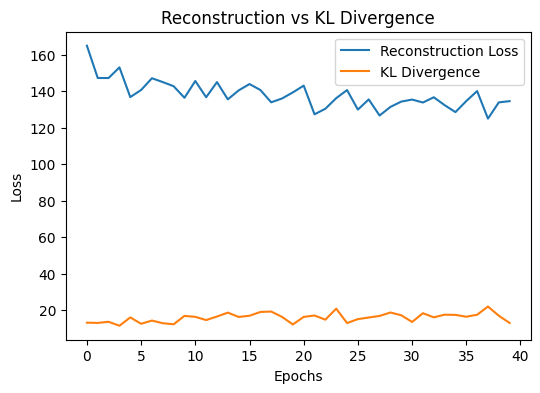

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(history.history["reconstruction_loss"], label="Reconstruction Loss")
plt.plot(history.history["kl_loss"], label="KL Divergence")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Reconstruction vs KL Divergence")
plt.legend()
plt.show()


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


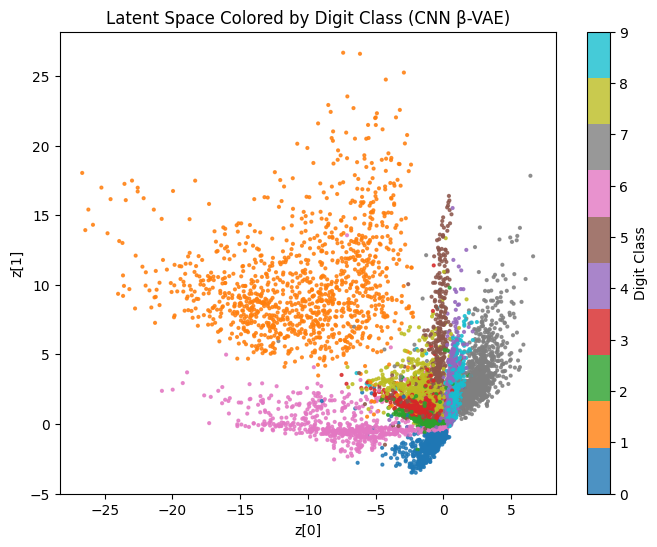

In [ ]:
z_mean, _, _ = encoder.predict(x_test, batch_size=128)

plt.figure(figsize=(8,6))
scatter = plt.scatter(
    z_mean[:, 0],
    z_mean[:, 1],
    c=y_test,
    cmap="tab10",
    s=4,
    alpha=0.8
)
plt.colorbar(scatter, label="Digit Class")
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title("Latent Space Colored by Digit Class (CNN β-VAE)")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


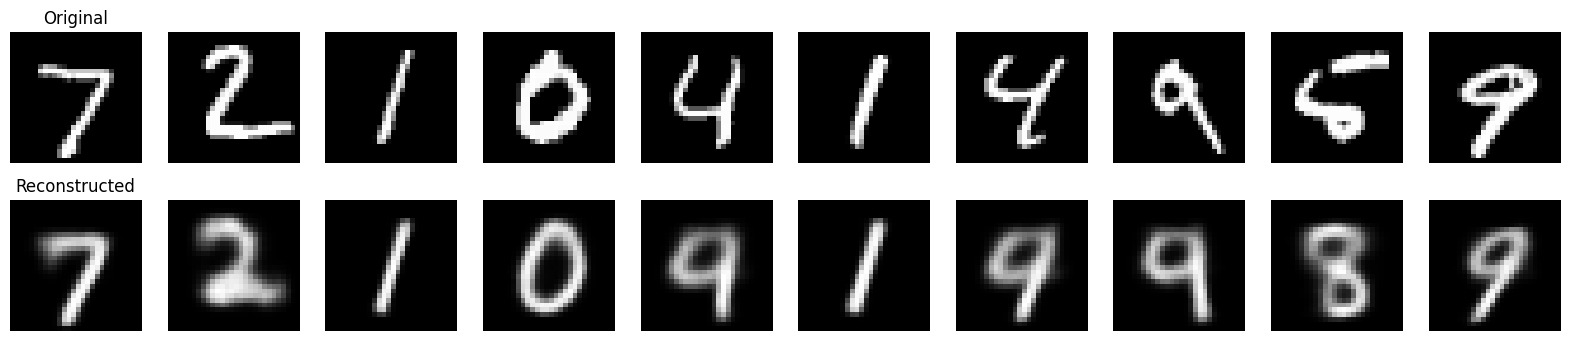

In [ ]:
n = 10
z_mean, _, z = encoder.predict(x_test[:n])
recon = decoder.predict(z)

plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    plt.axis("off")
    if i == 0: ax.set_title("Original")

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon[i].reshape(28, 28), cmap="gray")
    plt.axis("off")
    if i == 0: ax.set_title("Reconstructed")

plt.show()


In [ ]:
class VAE(Model):
    def __init__(self, encoder, decoder, beta):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            recon_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )

            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )

            total_loss = recon_loss + self.beta * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {
            "loss": total_loss,
            "reconstruction_loss": recon_loss,
            "kl_loss": kl_loss
        }


In [ ]:
betas = [0.01, 0.1, 1.0, 5.0]
histories = {}

for beta in betas:
    print(f"\nTraining with beta = {beta}")

    vae = VAE(encoder, decoder, beta=beta)
    vae.compile(optimizer=tf.keras.optimizers.Adam())

    history = vae.fit(
        x_train,
        epochs=30,
        batch_size=128,
        verbose=0
    )

    histories[beta] = history



Training with beta = 0.01

Training with beta = 0.1

Training with beta = 1.0

Training with beta = 5.0


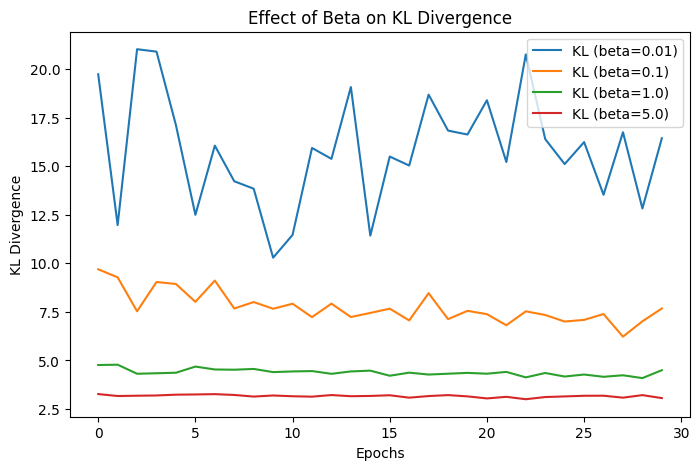

In [ ]:
plt.figure(figsize=(8, 5))

for beta, history in histories.items():
    plt.plot(
        history.history["kl_loss"],
        label=f"KL (beta={beta})"
    )

plt.xlabel("Epochs")
plt.ylabel("KL Divergence")
plt.title("Effect of Beta on KL Divergence")
plt.legend()
plt.show()


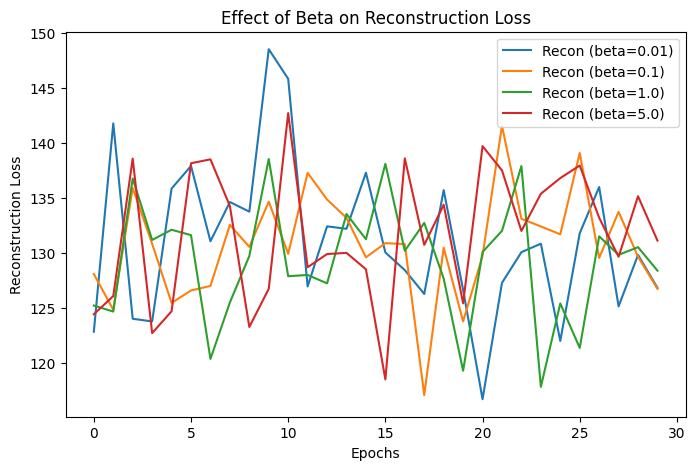

In [ ]:
plt.figure(figsize=(8, 5))

for beta, history in histories.items():
    plt.plot(
        history.history["reconstruction_loss"],
        label=f"Recon (beta={beta})"
    )

plt.xlabel("Epochs")
plt.ylabel("Reconstruction Loss")
plt.title("Effect of Beta on Reconstruction Loss")
plt.legend()
plt.show()


In [ ]:
class VAE(Model):
    def __init__(self, encoder, decoder, beta_start=0.0):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = tf.Variable(beta_start, trainable=False)


In [ ]:
def train_step(self, data):
    # KL annealing
    self.beta.assign(tf.minimum(1.0, self.beta + 0.001))

    with tf.GradientTape() as tape:
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)

        recon_loss = tf.reduce_mean(
            tf.reduce_sum(
                tf.keras.losses.binary_crossentropy(data, reconstruction),
                axis=(1, 2)
            )
        )

        kl_loss = -0.5 * tf.reduce_mean(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        )

        total_loss = recon_loss + self.beta * kl_loss

    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    return {
        "loss": total_loss,
        "reconstruction_loss": recon_loss,
        "kl_loss": kl_loss,
        "beta": self.beta
    }


In [ ]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, beta_start=0.0):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = tf.Variable(beta_start, trainable=False)

    # REQUIRED by Keras
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

    def train_step(self, data):
        # KL annealing
        self.beta.assign(tf.minimum(1.0, self.beta + 0.001))

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # Reconstruction loss
            recon_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )

            # KL divergence
            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )

            total_loss = recon_loss + self.beta * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {
            "loss": total_loss,
            "reconstruction_loss": recon_loss,
            "kl_loss": kl_loss,
            "beta": self.beta
        }


In [ ]:
vae = VAE(encoder, decoder, beta_start=0.0)
vae.compile(optimizer=tf.keras.optimizers.Adam())

history = vae.fit(
    x_train,
    epochs=40,
    batch_size=128
)


Epoch 1/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - beta: 0.2355 - kl_loss: 4.5081 - loss: 129.4469 - reconstruction_loss: 128.3669
Epoch 2/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - beta: 0.7045 - kl_loss: 4.2731 - loss: 131.1877 - reconstruction_loss: 128.1902
Epoch 3/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - beta: 0.9960 - kl_loss: 4.0818 - loss: 132.4457 - reconstruction_loss: 128.3804
Epoch 4/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - beta: 1.0000 - kl_loss: 4.0914 - loss: 132.2943 - reconstruction_loss: 128.2029
Epoch 5/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - beta: 1.0000 - kl_loss: 4.1084 - loss: 132.2699 - reconstruction_loss: 128.1615
Epoch 6/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - beta: 1.0000 - kl_loss: 4.1125 - loss: 132.2751 - reconstruction_loss: 128.1625
Epoch 7/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - beta: 1.0000 - kl_loss: 4.1243 - loss: 132.2045 - reconstruction_loss: 128.0802
Epoch 8/40
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - beta: 

In [ ]:
print("Final beta value:", vae.beta.numpy())


Final beta value: 1.0


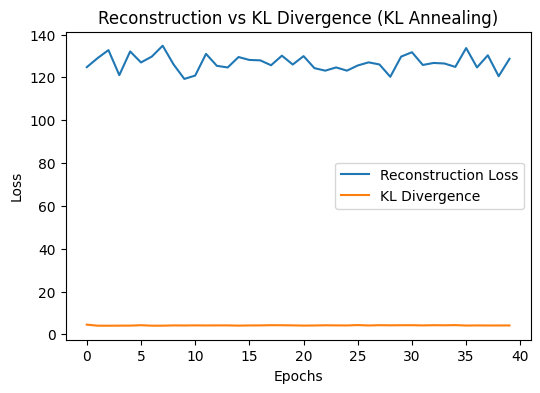

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(history.history["reconstruction_loss"], label="Reconstruction Loss")
plt.plot(history.history["kl_loss"], label="KL Divergence")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Reconstruction vs KL Divergence (KL Annealing)")
plt.legend()
plt.show()


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


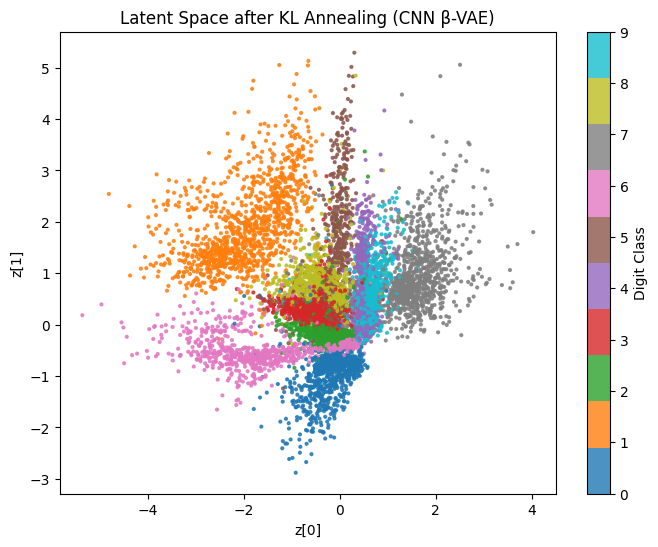

In [ ]:
z_mean, _, _ = encoder.predict(x_test, batch_size=128)

plt.figure(figsize=(8,6))
scatter = plt.scatter(
    z_mean[:, 0],
    z_mean[:, 1],
    c=y_test,
    cmap="tab10",
    s=4,
    alpha=0.8
)
plt.colorbar(scatter, label="Digit Class")
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title("Latent Space after KL Annealing (CNN β-VAE)")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


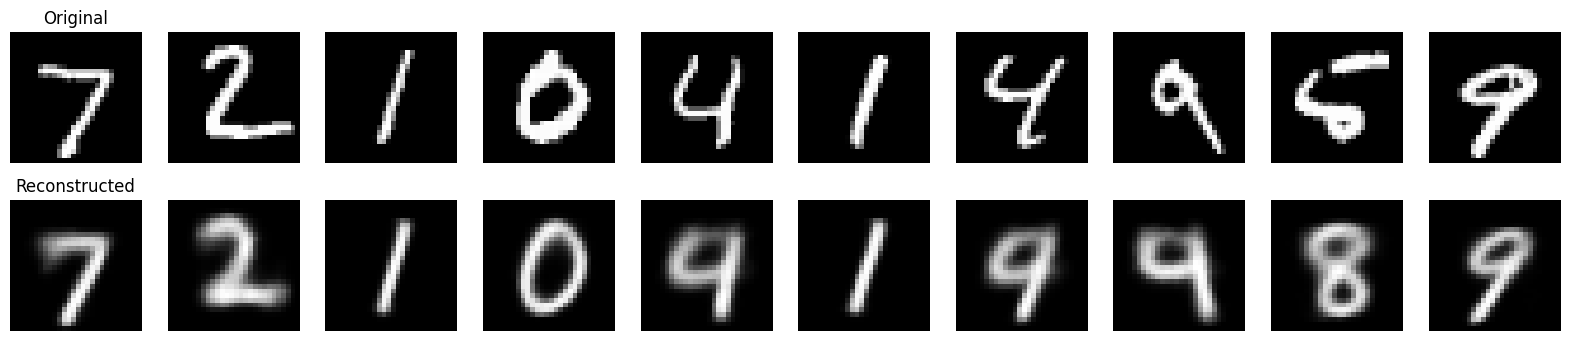

In [ ]:
n = 10
z_mean, _, z = encoder.predict(x_test[:n])
recon = decoder.predict(z)

plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    plt.axis("off")
    if i == 0: ax.set_title("Original")

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon[i].reshape(28, 28), cmap="gray")
    plt.axis("off")
    if i == 0: ax.set_title("Reconstructed")

plt.show()
